In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v1 import Autoencoder
from tools.ESN_v1_ensembleAR import ESN_ensemble as AR_RNN
from tools.AEESN_AR_v2 import AR_AERNN_ESN as AR_AERNN
from tools.trainAEESN_ensemble import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-21 17:21:10.536630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 17:21:10.536893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 17:21:10.572053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 17:21:10.572288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 17:21:10.572468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN_ensemble/ESN_ensemble_000'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AEESN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_ESN_ensemble_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/0_final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ESN_ensemble/ESN_ensemble_000
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_000
data_dir_idx: 000
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

# if use_ae_data == True:
#     if ae_data_with_params == True and alldata_withparams_flag == False:
#         new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
#         new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
#         del(all_data)
#         all_data = new_all_data
#         prev_idx = 0
#         for i in range(boundary_idx_arr.shape[0]):
#             all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
#             prev_idx = boundary_idx_arr[i]

#     if normalizeforae_flag == True:
#         for i in range(all_data.shape[1]):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:og_vars]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:og_vars]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
else:
    all_data = all_data[:, 0:og_vars]
    
normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:all_data.shape[1]]

In [14]:
print('all_data.shape : ', all_data.shape)
print('all_data.dtype : ', all_data.dtype)

all_data.shape :  (500026, 64)
all_data.dtype :  float64


# Autoencoder

In [15]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [16]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [17]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([
        # 5,
        10,
        30,
        40
    ])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [18]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        # [1e-3],
        [1e-4],
        [1e-5],
        [1e-6],
    ]
    epochs = [
        # [200],
        [200],
        [200],
        [200],
    ]
    patience = [
        # [10],
        [20],
        [20],
        [20],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 7e-9  # weight for regularizer
    covmat_lmda = 5e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    train_alpha = [False]*3
    train_omega_in = [False]*3
    train_rho_res = [False]*3
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [19]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }

In [20]:
def find_and_return_load_wt_file_lists(
        load_dir,
        wt_matcher='weights.hdf5',
        classdict_matcher='class_dict.txt',
    ):
    contents_load_dir = [f for f in os.listdir(load_dir) if os.path.isfile(os.path.join(load_dir, f))]
    load_files_lst = [f for f in contents_load_dir if f.endswith(classdict_matcher)]
    wt_files_lst = [f for f in contents_load_dir if f.endswith(wt_matcher)]

    load_files_lst_startingidx = []
    for i in range(len(load_files_lst)):
        fn = load_files_lst[i]
        idx = fn.find('_')
        load_files_lst_startingidx.append(int(fn[0:idx]))

    wt_files_lst_startingidx = []
    for i in range(len(wt_files_lst)):
        fn = wt_files_lst[i]
        idx = fn.find('_')
        wt_files_lst_startingidx.append(int(fn[0:idx]))

    load_files_sortidx = np.argsort(load_files_lst_startingidx)
    wt_files_sortidx = np.argsort(wt_files_lst_startingidx)

    load_files_lst = np.array(load_files_lst)[load_files_sortidx]
    wt_files_lst = np.array(wt_files_lst)[wt_files_sortidx]

    load_file_rnn = [load_dir + '/' + fn for fn in load_files_lst]
    wt_file_rnn = [load_dir + '/' +  fn for fn in wt_files_lst]
    
    return load_file_rnn, wt_file_rnn

In [21]:
load_dir = dir_name_rnn + '/final_net'
load_file_rnn, wt_file_rnn = find_and_return_load_wt_file_lists(load_dir)



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
71/71 [==============================] - ETA: 0s - loss: 0.0170 - mse: 0.0022 - NMSE: 0.0194 - NMSE_wt: 0.0169 - covmat_fro_loss: 0.0045 - global_gradnorm: 3.9167 - tot_time: 0h 1m 41.9s

Epoch 1: val_NMSE improved from inf to 0.00972, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR

Epoch 11/200
71/71 [==============================] - ETA: 0s - loss: 0.0075 - mse: 9.4410e-04 - NMSE: 0.0085 - NMSE_wt: 0.0074 - covmat_fro_loss: 0.0032 - global_gradnorm: 2.2261 - tot_time: 0h 9m 1.3s

Epoch 11: val_NMSE improved from 0.00868 to 0.00791, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 50s 709ms/step - loss: 0.0075 - mse: 9.4410e-04 - NMSE: 0.0085 - NMSE_wt: 0.0074 - covmat_fro_loss: 0.0032 - global_gradnorm: 2.2314 - val_loss: 0.0070 - val_mse: 8.7915e-04 - val_NMSE: 0.0079 - val_NMSE_wt: 0.0069 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
71/71 [==============================] - ETA: 0s - loss: 0.0072 - mse: 8.9960e-04 - NMSE: 0.0081 - NMSE_wt: 0.0

Epoch 22/200
71/71 [==============================] - ETA: 0s - loss: 0.0066 - mse: 8.2843e-04 - NMSE: 0.0075 - NMSE_wt: 0.0065 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.7057 - tot_time: 0h 16m 17.3s

Epoch 22: val_NMSE did not improve from 0.00791
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 30s 428ms/step - loss: 0.0066 - mse: 8.2843e-04 - NMSE: 0.0075 - NMSE_wt: 0.0065 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.7011 - val_loss: 0.0071 - val_mse: 8.8768e-04 - val_NMSE: 0.0080 - val_NMSE_wt: 0.0070 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 23/200
71/71 [==============================] - ETA: 0s - loss: 0.0068 - mse: 8.4453e-04 - NMSE: 0.0076 - NMSE_wt: 0.0066 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.7581 - tot_time: 0h 16m 47.6s

Epoch 23: val_NMSE did not improve from 0.00791
 - savin

Epoch 33/200
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 8.9324e-04 - NMSE: 0.0080 - NMSE_wt: 0.0070 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.7263 - tot_time: 0h 21m 47.8s

Epoch 33: val_NMSE did not improve from 0.00717
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 30s 422ms/step - loss: 0.0071 - mse: 8.9324e-04 - NMSE: 0.0080 - NMSE_wt: 0.0070 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.7223 - val_loss: 0.0074 - val_mse: 9.2078e-04 - val_NMSE: 0.0083 - val_NMSE_wt: 0.0072 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 34/200
71/71 [==============================] - ETA: 0s - loss: 0.0067 - mse: 8.3821e-04 - NMSE: 0.0075 - NMSE_wt: 0.0066 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.5888 - tot_time: 0h 22m 18.0s

Epoch 34: val_NMSE did not improve from 0.00717
 - savin

71/71 [==============================] - ETA: 0s - loss: 0.0065 - mse: 8.1638e-04 - NMSE: 0.0073 - NMSE_wt: 0.0064 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.5945 - tot_time: 0h 27m 32.8s

Epoch 44: val_NMSE did not improve from 0.00717
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 30s 421ms/step - loss: 0.0065 - mse: 8.1638e-04 - NMSE: 0.0073 - NMSE_wt: 0.0064 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.5994 - val_loss: 0.0085 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_NMSE_wt: 0.0084 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 45/200
71/71 [==============================] - ETA: 0s - loss: 0.0068 - mse: 8.4481e-04 - NMSE: 0.0076 - NMSE_wt: 0.0066 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.5855 - tot_time: 0h 28m 2.8s

Epoch 45: val_NMSE did not improve from 0.00717
 - saving loss histories a

Epoch 55/200
71/71 [==============================] - ETA: 0s - loss: 0.0065 - mse: 8.1177e-04 - NMSE: 0.0073 - NMSE_wt: 0.0064 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.4172 - tot_time: 0h 33m 3.3s

Epoch 55: val_NMSE improved from 0.00684 to 0.00667, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 30s 425ms/step - loss: 0.0065 - mse: 8.1177e-04 - NMSE: 0.0073 - NMSE_wt: 0.0064 - covmat_fro_loss: 0.0030 - global_gradnorm: 1.4132 - val_loss: 0.0060 - val_mse: 7.4107e-04 - val_NMSE: 0.0067 - val_NMSE_wt: 0.0058 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 56/200
71/71 [==============================] - ETA: 0s - loss: 0.0058 - mse: 7.2549e-04 - NMSE: 0.0065 - NMSE_wt: 0.

Epoch 66/200
71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 7.4693e-04 - NMSE: 0.0067 - NMSE_wt: 0.0059 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.2561 - tot_time: 0h 38m 37.0s

Epoch 66: val_NMSE did not improve from 0.00591
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 31s 444ms/step - loss: 0.0060 - mse: 7.4693e-04 - NMSE: 0.0067 - NMSE_wt: 0.0059 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.2558 - val_loss: 0.0072 - val_mse: 8.9680e-04 - val_NMSE: 0.0081 - val_NMSE_wt: 0.0070 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 67/200
71/71 [==============================] - ETA: 0s - loss: 0.0068 - mse: 8.5537e-04 - NMSE: 0.0077 - NMSE_wt: 0.0067 - covmat_fro_loss: 0.0031 - global_gradnorm: 1.3044 - tot_time: 0h 39m 8.8s

Epoch 67: val_NMSE did not improve from 0.00591
 - saving

71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 7.4412e-04 - NMSE: 0.0067 - NMSE_wt: 0.0058 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.1485 - tot_time: 0h 44m 23.6s

Epoch 77: val_NMSE did not improve from 0.00591
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 31s 443ms/step - loss: 0.0060 - mse: 7.4412e-04 - NMSE: 0.0067 - NMSE_wt: 0.0058 - covmat_fro_loss: 0.0029 - global_gradnorm: 1.1476 - val_loss: 0.0059 - val_mse: 7.3231e-04 - val_NMSE: 0.0066 - val_NMSE_wt: 0.0058 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 78/200
71/71 [==============================] - ETA: 0s - loss: 0.0057 - mse: 7.1004e-04 - NMSE: 0.0064 - NMSE_wt: 0.0056 - covmat_fro_loss: 0.0028 - global_gradnorm: 1.1923 - tot_time: 0h 44m 54.9s

Epoch 78: val_NMSE did not improve from 0.00591
 - saving loss histor

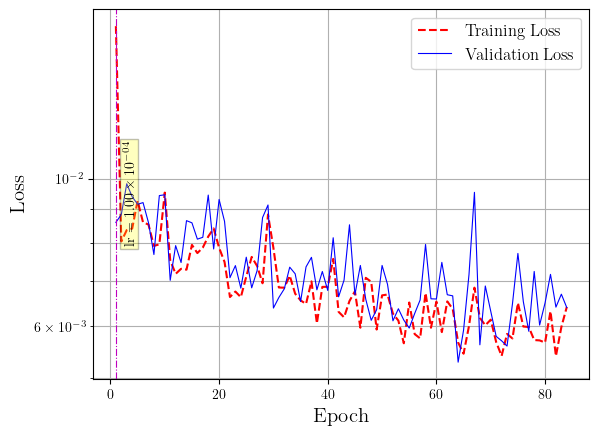

<Figure size 640x480 with 0 Axes>

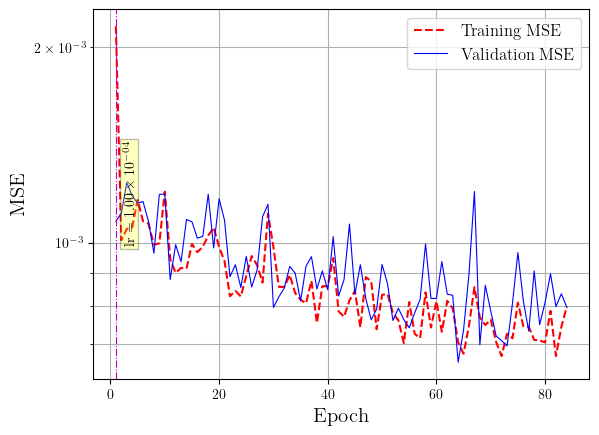

<Figure size 640x480 with 0 Axes>

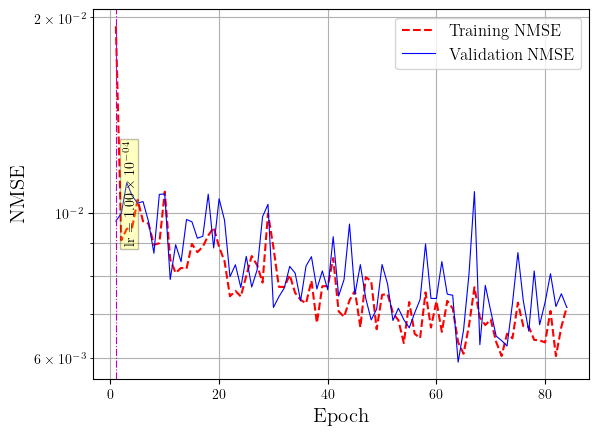

<Figure size 640x480 with 0 Axes>

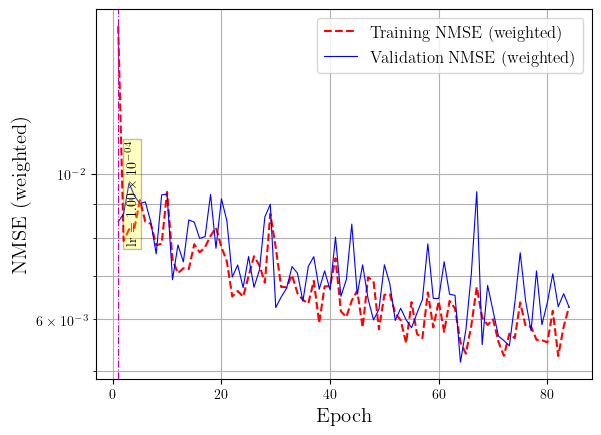

<Figure size 640x480 with 0 Axes>

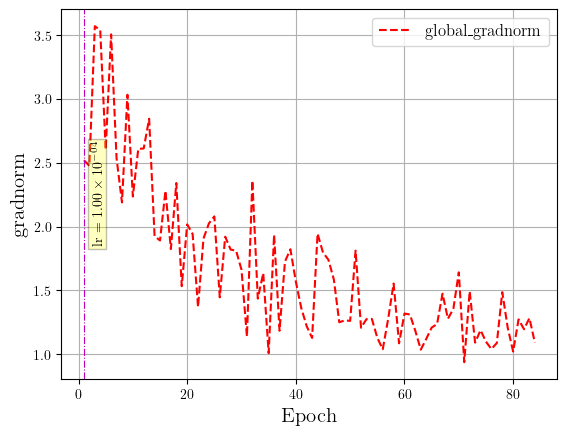



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 3.6


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
58/58 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0037 - NMSE: 0.0333 - NMSE_wt: 0.0214 - covmat_fro_loss: 0.0117 - global_gradnorm: 2.5049 - tot_time: 0h 4m 33.8s

Epoch 1: val_NMSE improved from inf to 0.03069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_003/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_

In [ ]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    
    load_dir = dir_name_ARrnn+'/final_net/{}_outsteps'.format(num_outsteps)
    load_file_rnn, wt_file_rnn = find_and_return_load_wt_file_lists(
        load_dir,
        wt_matcher='ESN_weights.hdf5',
        classdict_matcher='ESN_class_dict.txt'
    )
    
    load_file_ae = load_dir + '/final_net-{}_outsteps_ae_class_dict.txt'.format(num_outsteps)
    wt_file_ae = load_dir + '/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(load_dir+'/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.1 * np.round(10*global_clipnorm)

In [ ]:
### Training the combined AE-RNN


# 